# Mini Project: Transfer Learning with Keras

Transfer learning is a machine learning technique where a model trained on one task is used as a starting point to solve a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge learned from the source task and applies it to the target task. This approach is especially useful when the target task has limited data or computational resources.

In transfer learning, the pre-trained model, also known as the "base model" or "source model," is typically trained on a large dataset and a more general problem (e.g., image classification on ImageNet, a vast dataset with millions of labeled images). The knowledge learned by the base model in the form of feature representations and weights captures common patterns and features in the data.

To perform transfer learning, the following steps are commonly followed:

1. Pre-training: The base model is trained on a source task using a large dataset, which can take a considerable amount of time and computational resources.

2. Feature Extraction: After pre-training, the base model is used as a feature extractor. The last few layers (classifier layers) of the model are discarded, and the remaining layers (feature extraction layers) are retained. These layers serve as feature extractors, producing meaningful representations of the data.

3. Fine-tuning: The feature extraction layers and sometimes some of the earlier layers are connected to a new set of layers, often called the "classifier layers" or "task-specific layers." These layers are randomly initialized, and the model is trained on the target task with a smaller dataset. The weights of the base model can be frozen during fine-tuning, or they can be allowed to be updated with a lower learning rate to fine-tune the model for the target task.

Transfer learning has several benefits:

1. Reduced training time and resource requirements: Since the base model has already learned generic features, transfer learning can save time and resources compared to training a model from scratch.

2. Improved generalization: Transfer learning helps the model generalize better to the target task, especially when the target dataset is small and dissimilar from the source dataset.

3. Better performance: By starting from a model that is already trained on a large dataset, transfer learning can lead to better performance on the target task, especially in scenarios with limited data.

4. Effective feature extraction: The feature extraction layers of the pre-trained model can serve as powerful feature extractors for different tasks, even when the task domains differ.

Transfer learning is commonly used in various domains, including computer vision, natural language processing (NLP), and speech recognition, where pre-trained models are fine-tuned for specific applications like object detection, sentiment analysis, or speech-to-text.

In this mini-project you will perform fine-tuning using Keras with a pre-trained VGG16 model on the CIFAR-10 dataset.

First, import all the libraries you'll need.

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.image import resize

The CIFAR-10 dataset is a widely used benchmark dataset in the field of computer vision and machine learning. It stands for the "Canadian Institute for Advanced Research 10" dataset. CIFAR-10 was created by researchers at the CIFAR institute and was originally introduced as part of the Neural Information Processing Systems (NIPS) 2009 competition.

The dataset consists of 60,000 color images, each of size 32x32 pixels, belonging to ten different classes. Each class contains 6,000 images. The ten classes in CIFAR-10 are:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

The images are evenly distributed across the classes, making CIFAR-10 a balanced dataset. The dataset is divided into two sets: a training set and a test set. The training set contains 50,000 images, while the test set contains the remaining 10,000 images.

CIFAR-10 is often used for tasks such as image classification, object recognition, and transfer learning experiments. The relatively small size of the images and the variety of classes make it a challenging dataset for training machine learning models, especially deep neural networks. It also serves as a good dataset for teaching and learning purposes due to its manageable size and straightforward class labels.

Here are your tasks:

1. Load the CIFAR-10 dataset after referencing the documentation [here](https://keras.io/api/datasets/cifar10/).
2. Normalize the pixel values so they're all in the range [0, 1].
3. Apply One Hot Encoding to the train and test labels using the [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.
4. Further split the the training data into training and validation sets using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Use only 10% of the data for validation.  

In [13]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [14]:
# Normalize the pixel values to [0, 1]
for i in range(x_train.shape[0]):
    x_train[i,:, :] = x_train[i,:, :] - np.min(x_train[i,:, :])/(np.max(x_train[i,:, :])-np.min(x_train[i,:, :]))

for i in range(x_test.shape[0]):
    x_test[i,:, :] = x_test[i,:, :] - np.min(x_test[i,:, :])/(np.max(x_test[i,:, :])-np.min(x_test[i,:, :]))


In [15]:
# One-hot encode the labels
y_train_classes = to_categorical(y_train, num_classes=10)
y_test_classes = to_categorical(y_test, num_classes=10)

print(f'training labels encoded\n {y_train_classes[:5]}')
print(f'testing labels encoded\n {y_test_classes[:5]}')

training labels encoded
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
testing labels encoded
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [16]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_classes, test_size=0.30, random_state=42)

In [17]:
# reshaping images to vgg16 expected size
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [19]:
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
batch_size = 32
train_batches = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_batches = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_batches = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

VGG16 (Visual Geometry Group 16) is a deep convolutional neural network architecture that was developed by the Visual Geometry Group at the University of Oxford. It was proposed by researchers Karen Simonyan and Andrew Zisserman in their paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition," which was presented at the International Conference on Learning Representations (ICLR) in 2015.

The VGG16 architecture gained significant popularity for its simplicity and effectiveness in image classification tasks. It was one of the pioneering models that demonstrated the power of deeper neural networks for visual recognition tasks.

Key characteristics of the VGG16 architecture:

1. Architecture: VGG16 consists of a total of 16 layers, hence the name "16." These layers are stacked one after another, forming a deep neural network.

2. Convolutional Layers: The main building blocks of VGG16 are the convolutional layers. It primarily uses 3x3 convolutional filters throughout the network, which allows it to capture local features effectively.

3. Max Pooling: After each set of convolutional layers, VGG16 applies max-pooling layers with 2x2 filters and stride 2, which halves the spatial dimensions (width and height) of the feature maps and reduces the number of parameters.

4. Fully Connected Layers: Towards the end of the network, VGG16 has fully connected layers that act as a classifier to make predictions based on the learned features.

5. Activation Function: The network uses the Rectified Linear Unit (ReLU) activation function for all hidden layers, which helps with faster convergence during training.

6. Number of Filters: The number of filters in each convolutional layer is relatively small compared to more recent architectures like ResNet or InceptionNet. However, stacking multiple layers allows VGG16 to learn complex hierarchical features.

7. Output Layer: The output layer consists of 1000 units, corresponding to 1000 ImageNet classes. VGG16 was originally trained on the large-scale ImageNet dataset, which contains millions of images from 1000 different classes.

VGG16 was instrumental in showing that increasing the depth of a neural network can significantly improve its performance on image recognition tasks. However, the main drawback of VGG16 is its high number of parameters, making it computationally expensive and memory-intensive to train. Despite this limitation, VGG16 remains an essential benchmark architecture and has paved the way for even deeper and more efficient models in the field of computer vision, such as ResNet, DenseNet, and EfficientNet.

Here are your tasks:

1. Load [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) as a base model. Make sure to exclude the top layer.
2. Freeze all the layers in the base model. We'll be using these weights as a feature extraction layer to forward to layers that are trainable.

In [22]:
# Load the pre-trained VGG16 model (excluding the top classifier)
base_model = VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet",
    classifier_activation="softmax",)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
# for layer in base_model.layers:
#     layer.trainable = True

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Now, we'll add some trainable layers to the base model.

1. Using the base model, add a [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/) layer, followed by a [Dense](https://keras.io/api/layers/core_layers/dense/) layer of length 256 with ReLU activation. Finally, add a classification layer with 10 units, corresponding to the 10 CIFAR-10 classes, with softmax activation.
2. Create a Keras [Model](https://keras.io/api/models/model/) that takes in approproate inputs and outputs.

In [32]:
# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [33]:
# Add a fully connected layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

In [34]:
# Add the final classification layer with 10 units (for CIFAR-10 classes) and softmax activation
outputs = Dense(10, activation='softmax')(x)

In [35]:
# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

With your model complete it's time to train it and assess its performance.

1. Compile your model using an appropriate loss function. Feel free to play around with the optimizer, but a good starting optimizer might be Adam with a learning rate of 0.001.
2. Fit your model on the training data. Use the validation data to print the accuracy for each epoch. Try training for 10 epochs. Note, training can take a few hours so go ahead and grab a cup of coffee.

**Optional**: See if you can implement an [Early Stopping](https://keras.io/api/callbacks/early_stopping/) criteria as a callback function.

In [36]:
print(x_train.shape, y_train_classes.shape, x_val.shape, y_val.shape)

(35000, 32, 32, 3) (50000, 10) (15000, 32, 32, 3) (15000, 10)


In [42]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Train the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)
history = model.fit(train_batches, epochs=10, validation_data=val_batches, 
                    callbacks=[early_stopping], verbose=2)

Epoch 1/10
1094/1094 - 4174s - 4s/step - accuracy: 0.8653 - loss: 0.4045 - val_accuracy: 0.8637 - val_loss: 0.4046
Epoch 2/10
1094/1094 - 4144s - 4s/step - accuracy: 0.8909 - loss: 0.3178 - val_accuracy: 0.8722 - val_loss: 0.3794
Epoch 3/10
1094/1094 - 4360s - 4s/step - accuracy: 0.9017 - loss: 0.2867 - val_accuracy: 0.8742 - val_loss: 0.3785
Epoch 4/10
1094/1094 - 4238s - 4s/step - accuracy: 0.9095 - loss: 0.2642 - val_accuracy: 0.8742 - val_loss: 0.3788
Epoch 5/10
1094/1094 - 4269s - 4s/step - accuracy: 0.9160 - loss: 0.2452 - val_accuracy: 0.8761 - val_loss: 0.3859
Epoch 6/10
1094/1094 - 4130s - 4s/step - accuracy: 0.9229 - loss: 0.2256 - val_accuracy: 0.8761 - val_loss: 0.3979
Epoch 7/10
1094/1094 - 4082s - 4s/step - accuracy: 0.9282 - loss: 0.2080 - val_accuracy: 0.8748 - val_loss: 0.4110
Epoch 8/10
1094/1094 - 4034s - 4s/step - accuracy: 0.9340 - loss: 0.1918 - val_accuracy: 0.8731 - val_loss: 0.4215


With your model trained, it's time to assess how well it performs on the test data.

1. Use your trained model to calculate the accuracy on the test set. Is the model performance better than random?
2. Experiment! See if you can tweak your model to improve performance.  

In [47]:
model.save('./fine-tuned-model.keras')

In [48]:
from tensorflow.keras.models import load_model
model = load_model('fine-tuned-model.keras')

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [50]:
# redoing test batches again again because I used y_test instead of the one-hot encoded 
# y_test_classes to generate the test_batches
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_classes))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_batches = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [51]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_batches, verbose=0)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Test loss: 0.3953653872013092
Test accuracy: 0.871999979019165


In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
y_pred = model.predict(test_batches)

313/313 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step


In [90]:
cm_plot_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, (np.argmax(y_pred, axis=1)))


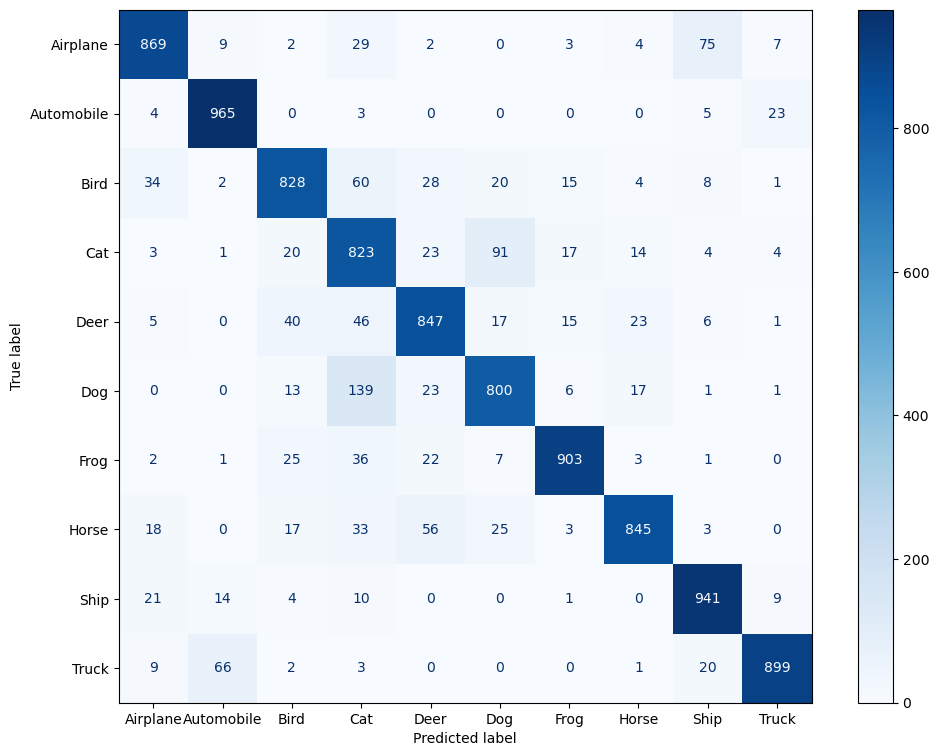

In [91]:
plt.figure(figsize=(12, 9)) 

# Plot using Scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot(cmap='Blues', ax=plt.gca())  # Use plt.gca() to get the current axis

plt.show()